<a href="https://colab.research.google.com/github/spyrosviz/Elderly-Fallers-Prediction/blob/main/Fallers_Prediction_Code/fallers_gait_features_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px
import plotly.graph_objects as go
!pip install bioinfokit
from bioinfokit.visuz import cluster

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import imputed whole dataset

df = pd.read_excel(r"/content/drive/MyDrive/Fallers_prediction/mixed_imputed_dataset.xlsx",index_col=0,skiprows=[1,23,40,50,71,72,73])

# if year falls greater than 0 set to 1
df["Year Fall"] = df["Year Fall"].replace([1,2,3,4,5,6,7,8,9,10],1)
y = df["Year Fall"].values
X = df.drop(["Year Fall",'6 Months Fall','yr almost'],axis=1).values
column_names = df.drop(["Year Fall",'6 Months Fall','yr almost'],axis=1).columns

In [ ]:
'''VIF'''

# detect multicollinearity with variance inflation factor

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
print(df_vif.sort_values(by=['VIF']))



                     Feature          VIF
23        tandem_eyes_closed     5.424698
35                dom_freq_v     6.893733
22          tandem_eyes_open     7.200427
2   Gender(1-female, 0-male)     8.456460
7                       PASE     9.742011
4                        GDS    11.670312
31               dom_freq_ml    12.870750
21    feet close eyes closed    13.978953
20      feet close eyes open    15.762245
27               dom_freq_ap    22.050917
33         dom_freq_width_ml    45.501753
11                      TMTa    46.710405
14                      FSST    56.295008
17                DGI stairs    72.776998
12                      TMTb    73.001870
6                      SF-36    88.737161
38          dom_freq_slope_v   117.150145
13                       TUG   119.029848
36           dom_freq_ampl_v   120.092252
5                  ABC Tot %   122.463616
29         dom_freq_width_ap   122.944606
37          dom_freq_width_v   125.898563
19              s3(velocity)   125

In [ ]:
'''Partial Least Squares VIP scores'''

# partial least squares vip scores (more suitable for variable selection when multicollinearity is present)
# we defined good predictors when vip score > 1, as it's suggested by the paper from Il-Gyo Chong & Chi-Hyuck Jun 2005
# function calculate_vips was taken from Keiron Teilo O'Shea, found on a researchgate forum
def calculate_vips(model):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

pls = PLSRegression()
pls.fit_transform(X,y)
vip = calculate_vips(pls)
df_pls_vip = pd.DataFrame()
df_pls_vip["Feature"] = column_names
df_pls_vip["VIP SCORE"] = vip
df_pls_vip["Beta SCORE"] = np.abs(pls.coef_)
print(df_pls_vip.sort_values(by = ["VIP SCORE"],ascending = False))

                     Feature  VIP SCORE  Beta SCORE
4                        GDS   1.751270    0.085776
6                      SF-36   1.639909    0.077089
37          dom_freq_width_v   1.459401    0.068293
20      feet close eyes open   1.407469    0.067051
22          tandem_eyes_open   1.404405    0.068768
13                       TUG   1.381598    0.010754
18            base(velocity)   1.266474    0.020878
26                  sampen_v   1.229381    0.060253
19              s3(velocity)   1.206356    0.015233
16                       DGI   1.176521    0.001356
36           dom_freq_ampl_v   1.171024    0.043816
15                      BERG   1.164838    0.012742
5                  ABC Tot %   1.160374    0.043680
14                      FSST   1.126361    0.012375
21    feet close eyes closed   1.112443    0.043955
17                DGI stairs   1.059173    0.010870
7                       PASE   0.985149    0.020551
10                       FAB   0.965744    0.046093
35          

In [ ]:
'''Principal Component Analysis'''

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)
pca_df = pd.DataFrame(pca_features,columns=['PCA1','PCA2','PCA3'])
target_var = []
for i in y:
  if i == 0:
    target_var.append('Non Faller')
  else:
    target_var.append('Faller')
df_target_var = pd.DataFrame(target_var,columns=['Group'])
df_pca = pd.concat([pca_df,df_target_var],axis=1)
loading_scores = pca.components_
df_loadings = pd.DataFrame(loading_scores.T,columns=['PCA1','PCA2','PCA3'],index=column_names)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance,decimals=2))
df_explained_var = pd.concat([pd.DataFrame(['PCA1','PCA2','PCA3'],columns=['PC']),
                              pd.DataFrame(explained_variance,columns=['Explained Variance']),
                              pd.DataFrame(cumulative_variance,columns=['Cumulative Variance'])],axis=1)
print(df_loadings)

                              PCA1      PCA2      PCA3
GCS (Neurotrax)          -0.188579 -0.056643  0.153910
EFI (Exe. Func. Index)   -0.175828 -0.042447  0.229506
Gender(1-female, 0-male)  0.141187 -0.066928 -0.001533
Age                       0.063411  0.010685 -0.150478
GDS                       0.064783 -0.106166  0.144653
ABC Tot %                -0.178289  0.045844 -0.229918
SF-36                    -0.146789  0.087941 -0.203176
PASE                     -0.154986 -0.039501 -0.159868
MMSE                     -0.088095 -0.116655  0.077562
MoCa                     -0.046953 -0.259088  0.287814
FAB                      -0.098166 -0.094429  0.164845
TMTa                      0.105958  0.148978 -0.210923
TMTb                      0.205443  0.137038 -0.193067
TUG                       0.287633 -0.001015 -0.027861
FSST                      0.262442  0.025916 -0.050126
BERG                     -0.264208 -0.065726 -0.097880
DGI                      -0.263422  0.017776 -0.123367
DGI stairs

In [ ]:
# Scree Plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_explained_var['PC'],y=df_explained_var['Explained Variance'],marker=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=df_explained_var['PC'],y=df_explained_var['Cumulative Variance'],marker=dict(size=12,color='DarkViolet')))
fig.show()

In [ ]:
# PCA components 3d plot

fig = px.scatter_3d(df_pca,x='PCA1',y='PCA2',z='PCA3',color=df_pca['Group'],opacity=0.5)
fig.update_layout(template='plotly_dark')

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, feature in enumerate(column_names):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [ ]:
# Loading scores plot

loading_scores_labels = df_loadings.index
fig = px.scatter_3d(df_loadings,x='PCA1',y='PCA2',z='PCA3',text=loading_scores_labels)
fig.show()

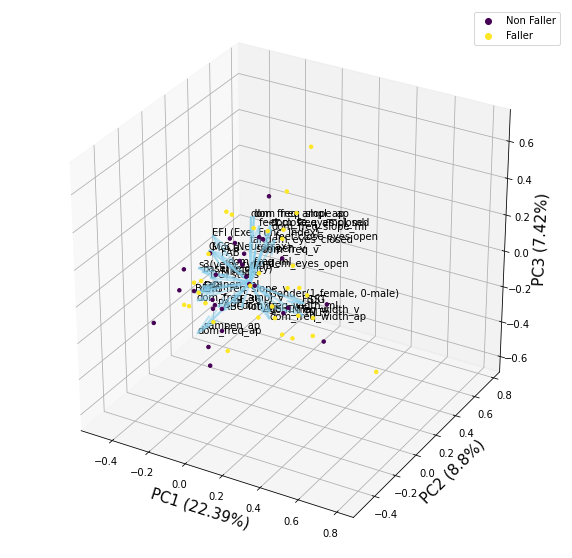

In [ ]:
'''PCA Biplot'''

cluster.biplot(cscore=pca_features,loadings=loading_scores,labels=loading_scores_labels,
                var1=np.round(df_explained_var['Explained Variance'][0]*100,2),
               var2=np.round(df_explained_var['Explained Variance'][1]*100,2),
               var3=np.round(df_explained_var['Explained Variance'][2]*100,2),
               show=True,colorlist=target_var,dim=(10,10),dotsize=12,arrowlinewidth=2,axlabelfontsize=15,
               valphaarrow=0.5)

### **We observe that the 3 principal components explain a small percentage of variance in the dataset. Thus we have lost a lot information and cannot have valid insights**

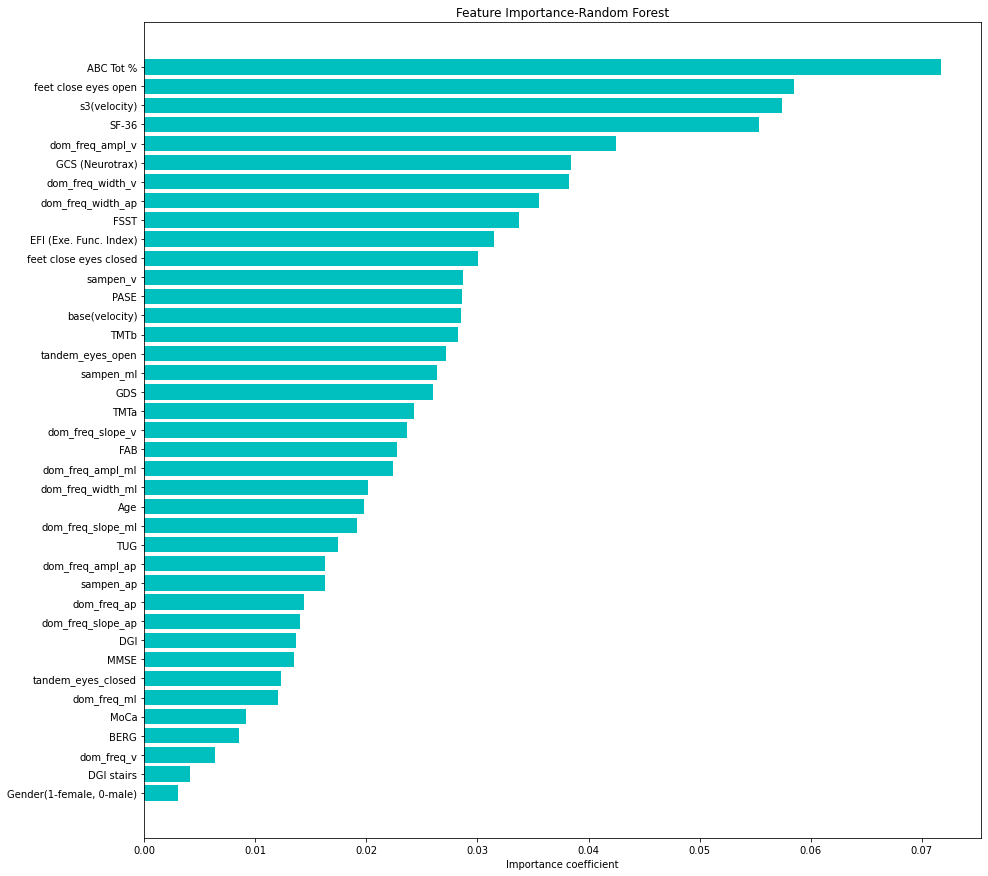

In [ ]:
'''Random Forest Classifier'''

# use random forest to find feature importance coefficients
rand_for = RandomForestClassifier()
rand_for.fit(X,y)
feature_importance = rand_for.feature_importances_
indices = np.argsort(feature_importance)

# plot random forest feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(indices)),feature_importance[indices],color ="c",align="center")
plt.yticks(range(len(indices)),[column_names[i] for i in indices])
plt.title("Feature Importance-Random Forest")
plt.xlabel("Importance coefficient")
plt.show()

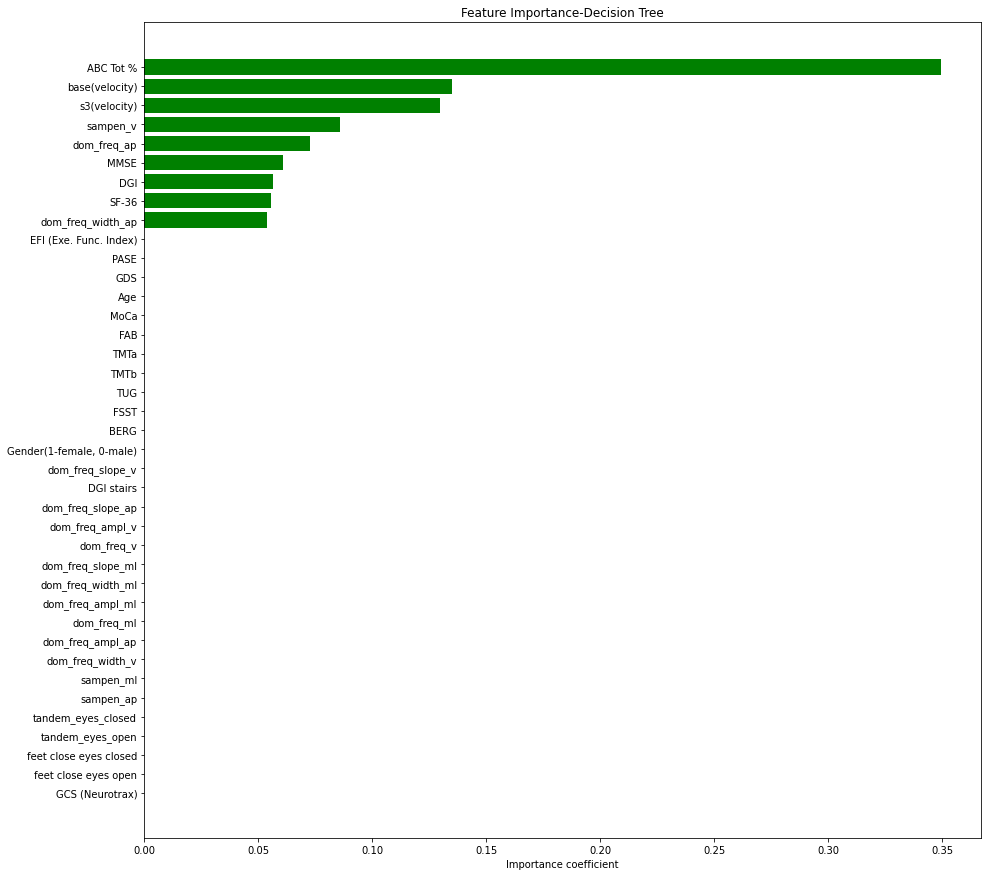

In [ ]:
'''Decision Tree'''

# use decision tree to find feature importance coefficients
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X,y)
best_features = dec_tree.feature_importances_
index = np.argsort(best_features)

# plot decision tree feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(index)),best_features[index],color ="g",align="center")
plt.yticks(range(len(index)),[column_names[i] for i in index])
plt.title("Feature Importance-Decision Tree")
plt.xlabel("Importance coefficient")
plt.show()